<a href="https://colab.research.google.com/github/Sylvariane/prediction_revenus/blob/main/P07_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction de revenus

In [1]:
# connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('talk')
sns.set_palette('Set1')

In [4]:
data = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/data-projet7.csv')

In [5]:
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


**Mission 1**


Résumez les données utilisées :
- Année(s) des données utilisées ;
- Nombre de pays présents ;
- Population couverte par l'analyse (en termes de pourcentage de la population mondiale).


Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.
- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.


L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents.

In [6]:
year_survey = data['year_survey'].unique()
print(np.sort(year_survey))

[2004 2006 2007 2008 2009 2010 2011]


Les années présentées dans l'échantillon sont 2004, 2006, 2007, 2008, 2009, 2010 et 2011.

In [7]:
country = data['country'].unique()
print('Nombre de pays présents dans l\'échantillon : ', len(country))

Nombre de pays présents dans l'échantillon :  116


In [8]:
country_iso = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/sql-pays.csv', header=None)

In [9]:
country_iso.columns = ['0', '1', '2', 'Code ISO', 'Pays', '5']
country_iso = country_iso[['Code ISO', 'Pays']]

In [10]:
data = pd.merge(data, country_iso, left_on='country', right_on='Code ISO')
data = data[['Code ISO', 'Pays', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
data.head()

,Code ISO,Pays,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,Albanie,2008,1,100,"728,89795",7297
1,ALB,Albanie,2008,2,100,"916,66235",7297
2,ALB,Albanie,2008,3,100,"1010,916",7297
3,ALB,Albanie,2008,4,100,"1086,9078",7297
4,ALB,Albanie,2008,5,100,"1132,6997",7297


In [11]:
pop_fao = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/population_2008.csv')

In [12]:
pop_fao  = pop_fao[['Zone', 'Valeur']]
pop_fao['Valeur'] = pop_fao['Valeur'] * 1000
data = pd.merge(data, pop_fao, right_on='Zone', left_on='Pays')

In [13]:
pop_total = sum(pop_fao['Valeur'])
pop_data = data['Valeur'].groupby(data['Pays']).mean()
pourcent_pop_ech = round((pop_data.sum()/pop_total) * 100, 2)
print('Population couverte par l\'analyse : ' + str(pourcent_pop_ech) + '%.')

Population couverte par l'analyse : 84.14%.


In [14]:
# Suppression des dataframes non utiles à la suite de l'étude
del pop_fao
del country_iso

In [16]:
# Suppression des colonnes non utilisées dans la suite de l'étude
data = data.drop(columns=['Zone', 'Valeur'])

Pour chaque pays, les revenus sont présentés sous la forme de centiles. On dispose de 100 classes de revenus par pays. L'avantage de ce découpage permet de gommer les écarts entre les pays. De plus, on va avoir tendance à voir moins de valeurs qui vont être influencés par des valeurs aberrantes comme cela serait le cas pour une moyenne par exemple.

**Définition de méthode Eltöte-Köves-Szulc** : il s'agit d'une méthode statistique qui permet de calculer la parité de pouvoir d'achat. Elle a l'avantage de donner un poids à chaque pays et ainsi favoriser la comparaison entre différents pays.

**Mission 2**

- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
- Représentez la courbe de Lorenz de chacun des pays choisis.
- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?


In [17]:
# Choix de 10 pays pour la suite de l'analyse
data = data.set_index('Pays')
df = data.loc(axis=0)['France', 'Géorgie', 'Canada', 'Honduras', 'Colombie', 'Brésil', 'Yémen', 'Fédération de Russie', 'Philippines', 'Thaïlande'].reset_index()
df = df.sort_values('Pays')
df.head()

,Pays,Code ISO,year_survey,quantile,nb_quantiles,income,gdpppp
501,Brésil,BRA,2008,2,100,"245,92259",9559
528,Brésil,BRA,2008,29,100,"1641,4523",9559
529,Brésil,BRA,2008,30,100,"1645,82",9559
530,Brésil,BRA,2008,31,100,"1682,6384",9559
531,Brésil,BRA,2008,32,100,"1747,4269",9559


In [18]:
# modification de la classe de 'income'
# création de la classe 'income_log10'
df['income'] = df['income'].str.replace(',', ".")
df['income'] = df['income'].apply(lambda x: float(x))
df['income_log10'] = df['income'].apply(lambda x: math.log10(x)) 
df.head()

,Pays,Code ISO,year_survey,quantile,nb_quantiles,income,gdpppp,income_log10
501,Brésil,BRA,2008,2,100,245.92259,9559,2.390798
528,Brésil,BRA,2008,29,100,1641.45230,9559,3.215228
529,Brésil,BRA,2008,30,100,1645.82000,9559,3.216382
530,Brésil,BRA,2008,31,100,1682.63840,9559,3.225991
531,Brésil,BRA,2008,32,100,1747.42690,9559,3.242399


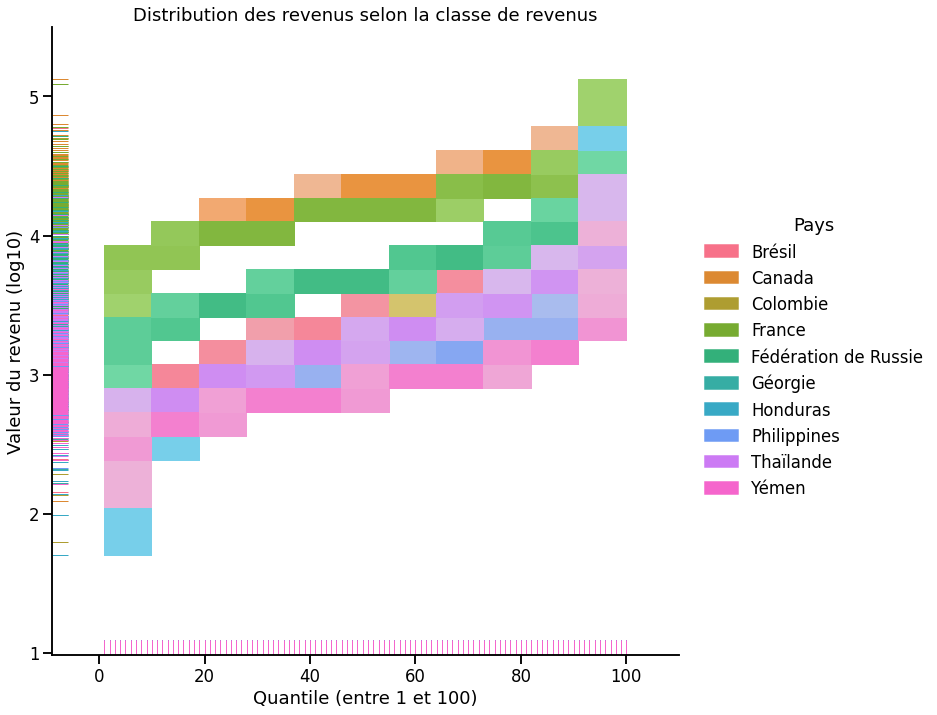

In [19]:
# Affichage de la distribution des revenus en fonction de la classe de revenus
_ = sns.displot(x='quantile', y='income_log10', hue='Pays', rug=True, height=10, data=df)
_ = plt.title('Distribution des revenus selon la classe de revenus')
_ = plt.xlabel('Quantile (entre 1 et 100)')
_ = plt.ylabel('Valeur du revenu (log10)')
_ = plt.show()